# Pixel Amplifier Testing & Calibration via Guard Ring

In order to test the Charge Sensitive Amplifiers (CSA) within the pixels, we need to inject charge into the inputs of the amplifiers. We do this using the parasitic capacitance of the guard ring structure, which surrounds the topmetal input electrodes of the pixels. By injecting a known square wave pulse into the guard ring, we can look at the corresponding pixel response to calibrate our amplifiers.

Let's take a look at this by selecting out a single pixel from the array (which we do by stopping the clock on that pixel) and injecting a pulse.

In [189]:
#Initial block to set import and set defaults
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.special import expit
from scipy.optimize import curve_fit

import sys

sys.path.append('../../Software/SeAl/')
import waveform_analysis.filter_methods as f_methods


mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
 
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18

mpl.rc('axes', titlesize=20)
mpl.rcParams['figure.figsize'] = [7, 7]
import uproot


I am including some test waveforms to visualize this (located in data/).

These are a select group of single pixels from a specific calibration run of an entire bare die chip and are meant to be an example of the procedure and results. 

These are not necessarily representative final chip performance/characteristics.

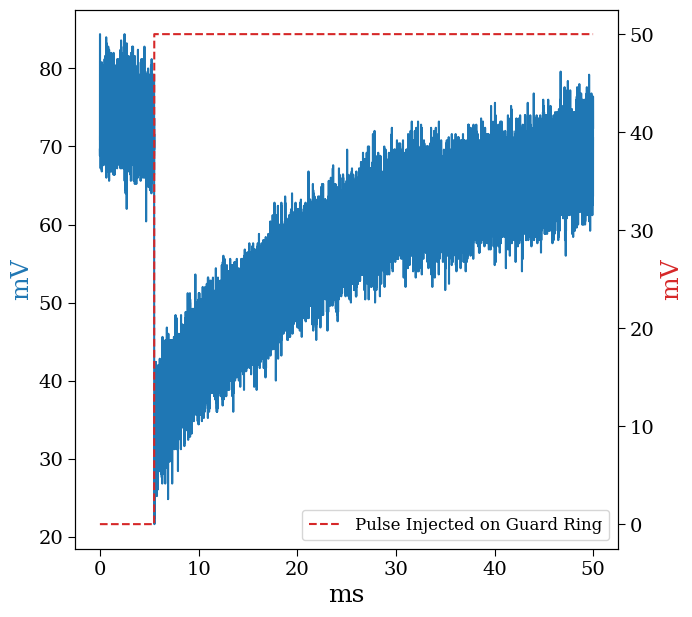

In [190]:
fname = 'data/LA_pixel2120.root'
tFile = uproot.open(fname)
fHeaderDir = tFile["Header/"]
tTree = tFile['wfTree']

tscale, yscale = f_methods.get_xyscale(waveform)
wf_0 = tTree.iterate(step_size=50, library='numpy')
for wf in wf_0:
    v = wf['wf'][0, :]* yscale
    v = v[10:-10]
    t = np.arange(0, len(v), 1) * tscale  #ms
    
fig,ax1 = plt.subplots()

ax1.plot(t, v, label='Pixel 3201 CSA Response')
plt.xlabel("ms")
plt.ylabel("mV", color='tab:blue')

#Plot Guard Ring Pulse

gring_height = float(fHeaderDir["Calibration/gring_height"])
pulse = gring_height*np.heaviside(t - 5.5, 1)

ax2=ax1.twinx()
ax2.plot(t, pulse, color='tab:red', label='Pulse Injected on Guard Ring', ls='dashed')
ax2.set_ylabel('mV', color='tab:red')

ax2.legend()

This plot represents the single pixel analog response to a pulse from the guard ring, which occurs roughly at ~5.5 ms. In this case, there is a visible decay to the pulse, which is due to the RC decay of the charge sensitive amplifier.

The red dashed line represents the pulse sent in from the function generator to the guard ring.

# Waveform Fit
We now want to fit these waveforms with a pulse with an exponential decay. 


To do this, we use the following function:
$$
    P(t) = \sigma(t_0, \alpha) \times \left[P_0 \exp[-(t-t_0)/\tau] \right]+ b \\
    \sigma(t0, \alpha) = \frac{\alpha}{1+\exp[-(t-t_0)]}
$$

This will give us our first estimate of the gain, decay time, baseline, and trigger location.



 Trigger Loc: 5.50ms
 Rise Coeff: 22511
 Pulse Height: -37.86mV
 tau: 21.47ms
 Baseline 73.18mV


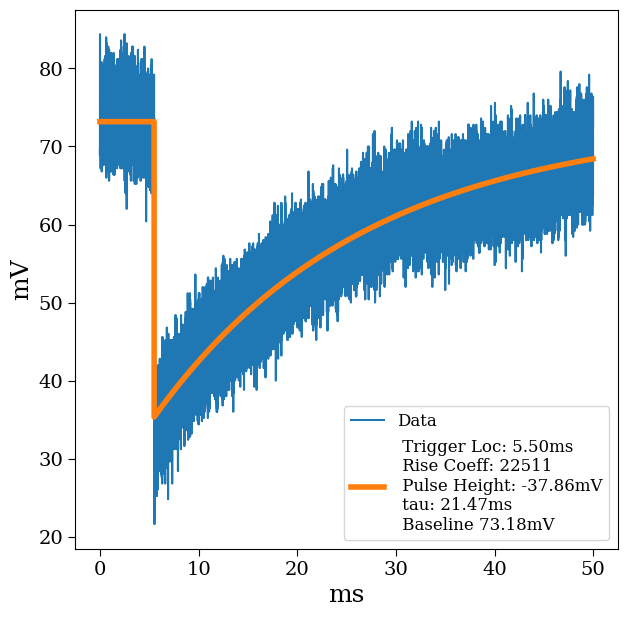

In [191]:
params, pcov = curve_fit(f_methods.pulse_func, t, v, p0 = [5, 2000,-40, 90, 75], maxfev=3000)

plt.plot(t, v, label = 'Data')
plt.plot(t, f_methods.pulse_func(t, *params), label = " Trigger Loc: %.2fms\n Rise Coeff: %i\n Pulse Height: %.2fmV\n tau: %.2fms\n Baseline %.2fmV" 
            %(params[0], params[1], params[2], params[3], params[4]), linewidth=4)
#plt.plot(t[:10000], wf[:10000])
plt.xlabel("ms")
plt.ylabel("mV")
plt.legend()
print(" Trigger Loc: %.2fms\n Rise Coeff: %i\n Pulse Height: %.2fmV\n tau: %.2fms\n Baseline %.2fmV" %(params[0], params[1], params[2], params[3], params[4]))

Note: the "Rise Coeff" term is necessary for the fast pulse, but does not represent anything important/physical. 

The other terms should be self-explanatory. 

## DSP: Pole Zero Correction and Trapezoidal Filtering


Below we do the Pole Zero Correction as well as the trapezoidal filtering. 

The Pole Zero requires prior knowledge of the decay time, which we got from the fit above.

The rise and flat times of the trapezoidal filter are inputs.

5000 1000


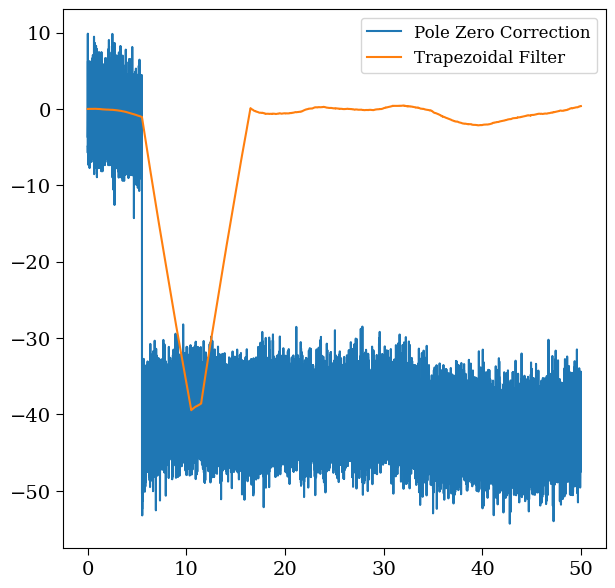

In [192]:
rise = int(5/tscale) #value is in ms, converted into no.samples
flat = int(1 /tscale) 
tau  = int(params[3] / tscale)
print(rise, flat)

pz = f_methods.pz_correct(v, tau)
tf = f_methods.trap_filter(pz, rise, flat)

tf_0 = f_methods.trap_filter(v- np.mean(v[:1000]), rise, flat)
#plt.plot(t,wf-np.mean(wf[:1000]))
plt.plot(t,pz, label = "Pole Zero Correction")
plt.plot(t,tf, label = "Trapezoidal Filter")
#plt.plot(t, tf_0, label = "Trap. Filter, no PZ")
plt.legend()

## Pulse Height Extraction

We now want to zoom in to the flat pulse of the trapezoidal filter and extract the height.


-38.95021003379282


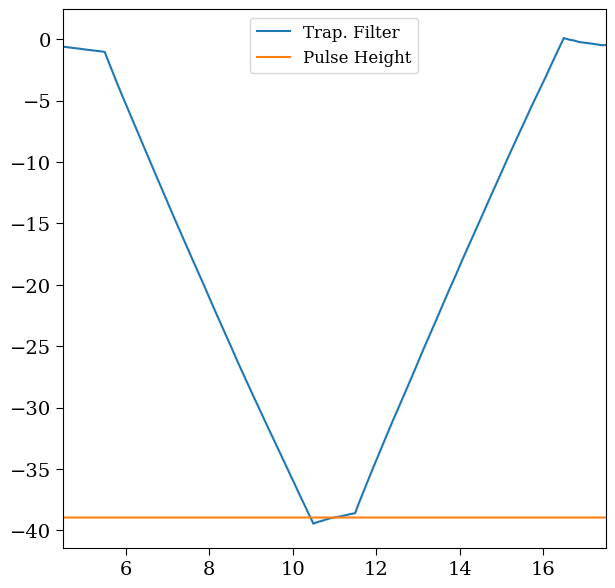

In [193]:
trigger_loc = int(params[0]/tscale)

height = f_methods.get_height(tf, trigger_loc, rise, flat)
plt.plot(t,tf, label = "Trap. Filter")
plt.xlim(params[0]-1, params[0]+(2* rise + flat)*tscale+1)
plt.plot(t ,[height]*len(t), label = "Pulse Height")
plt.legend()
print(height)

So final pulse height for this waveform is -40 mV, given a rise time of 5 ms. 

In order to fully characterize this pixel, we repeat this procedure multiple times and record the pulse height.
For the total distribution of pulse heights, the mean represents the gain of the amplifier and the RMS represents the noise. 

Now, in a trapezodial filter, the pulse height is dependent on the rise time. We characterize the pulse height distribution at multiple rise times (from 10 us to 10 ms). 


In [194]:
pulse_heights=[]
rise_times = np.logspace(-2, 1, num=20)

for v in wf['wf']:

    v = v * yscale
    v = v[10:-10]
    t = np.arange(0, len(v), 1) * tscale  #ms
    rise = int(1/tscale) #value is in ms, converted into no.samples
    flat = int(1 /tscale) 
    tau  = int(params[3] / tscale)


    pz = f_methods.pz_correct(v, tau)
    
    heights=[]
    for rt in rise_times:
        rise = int(rt/tscale)
    
        tf = f_methods.trap_filter(pz, rise, flat)
        height = f_methods.get_height(tf, trigger_loc, rise, flat)
        heights.append(height)
        
    pulse_heights.append(heights)
pulse_heights=np.array(pulse_heights)

means = np.mean(pulse_heights,0)
noise = np.std(pulse_heights,0)

We then plot the noise of the amplifier as a function of the rise time, demonstrating an optimal filter rise time. 

This curve is characteristic of these types of readout systems.

Text(0, 0.5, 'RMS (mV)')

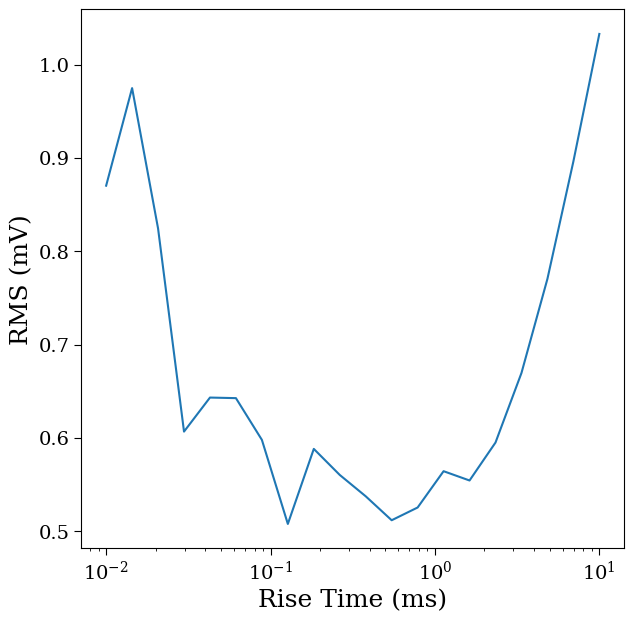

In [195]:
plt.plot(rise_times, noise)
plt.xscale('log')
plt.xlabel('Rise Time (ms)')
plt.ylabel('RMS (mV)')

For a given rise time, we can also plot the mean signal height. We can divide the number of injected electrons by the mean signal height to return the gain of the amplifier, in terms of electrons / mV.

We can multiply the gain by the noise to return the Equivalent Noise Charge (ENC), which is the RMS in units of electrons.

The number of injected electrons is given by the injected pulse height multiplied by the capacitance between the guard ring and the amplifier input.


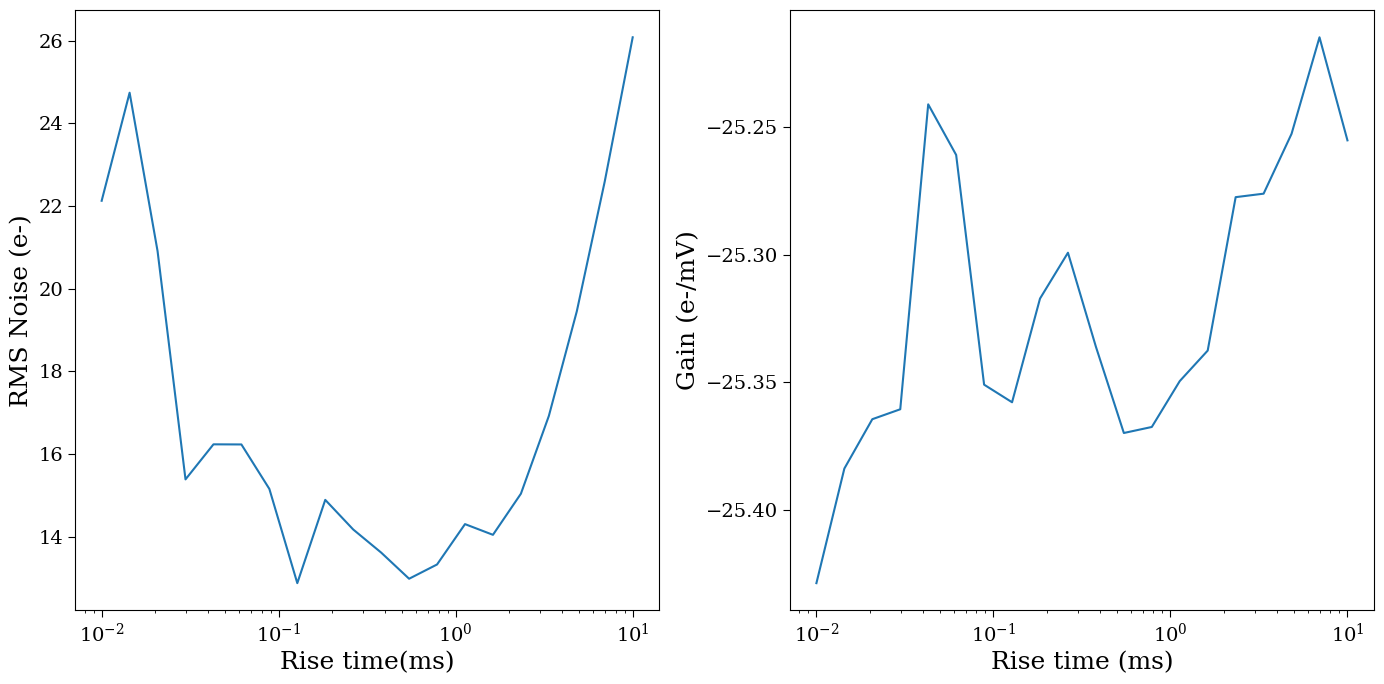

In [199]:
def gring_mV_to_e(gring_height):
    return gring_height * 19.3

e_injected = gring_mV_to_e(gring_height)
gain = e_injected / means
ENC = noise * gain * -1


mpl.rcParams['figure.figsize'] = [14, 7]
fig, axs = plt.subplots(1,2)

rise_times 

axs[0].plot(rise_times, ENC )
axs[0].set_xscale('log')
axs[0].set_xlabel("Rise time(ms)")
axs[0].set_ylabel("RMS Noise (e-)")
#axs[0].set_yticks((np.arange(np.min(mV_noise*e_gain),np.max(mV_noise*e_gain),5)))

axs[1].plot(rise_times, gain)
axs[1].set_xscale('log')
axs[1].set_xlabel("Rise time (ms)")
axs[1].set_ylabel("Gain (e-/mV)")
fig.tight_layout()
fig = plt.gcf()
mpl.rcParams['figure.figsize'] = [7, 7]


As you can see, with the optimal signal processing, we can achieve a roughly ~15 electron ENC for this particular pixel.